In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from la_forge.core import Core

import defiant
from defiant import OptimalStatistic
from defiant import utils, orf_functions, null_distribution as nulls
from defiant import plotting as defplot

from defiant.extra import mdc1_utils


print("Using defiant from:",defiant.__file__)

Using defiant from: /Users/gersbaka/Documents/Projects/Software_dev/defiant/defiant/__init__.py


In [2]:
# Returns both the list of pulsars and the injected parameters
psrs,inj_params = mdc1_utils.get_MDC1_psrs() 
# Create the PTA based on the pulsars loaded
pta = mdc1_utils.create_MDC1_PTA(psrs, gwb_components=10, gwb_name='gw') 


# For future plots, we will want the injected spectrum too
fgw = utils.get_pta_frequencies(pta, gwb_name='gw') # You can also get this with os_obj.freqs
inj_spectrum = utils.powerlaw(fgw, inj_params['gw_log10_A'], inj_params['gw_gamma'])

Loading MDC1 psrs:   0%|          | 0/36 [00:00<?, ?it/s]

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [3]:
to_sample = False

if to_sample:
    from enterprise_extensions.sampler import setup_sampler

    chain_loc = 'MDC1_FG_CURN_samples/'

    # Use enterprise_extensions setup_sampler to speed up the process!
    sampler = setup_sampler(pta, chain_loc, resume=True, human='KAG')

    x0 = np.hstack([p.sample() for p in pta.params]) # Get an initial sample

    sampler.sample(x0, Niter=int(1e6)) # Run a million samples

    lfcore = Core(chaindir=chain_loc)

    lfcore.save('MDC1_FG_CURN_samples.core')
    
else:
    # Load in the core object
    lfcore = Core(corepath='./MDC1_FG_CURN_samples.core')

In [5]:
# Since we created our PTA object with 'gw' as the name, make sure to set that!
OS_obj = OptimalStatistic(psrs, pta=pta, gwb_name='gw', core=lfcore, orfs=['hd'])

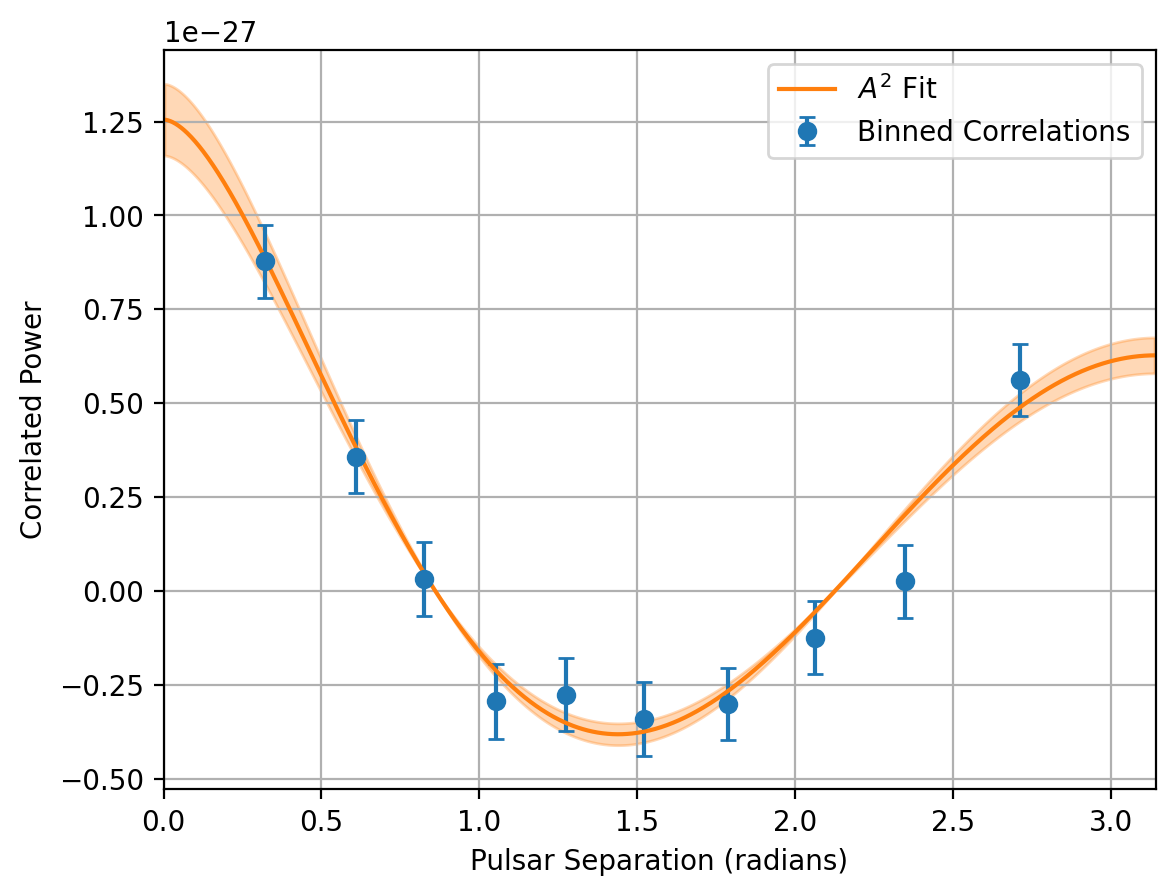

In [8]:
OS_obj.set_orf(['hd'])
xi,rho,sig,C,A2,A2s,idx = OS_obj.compute_OS(params=inj_params)

defplot.create_correlation_plot(xi,rho,sig,C,A2,A2s,bins=10);

## Phase shifting

### single-component

shifts:   0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.0


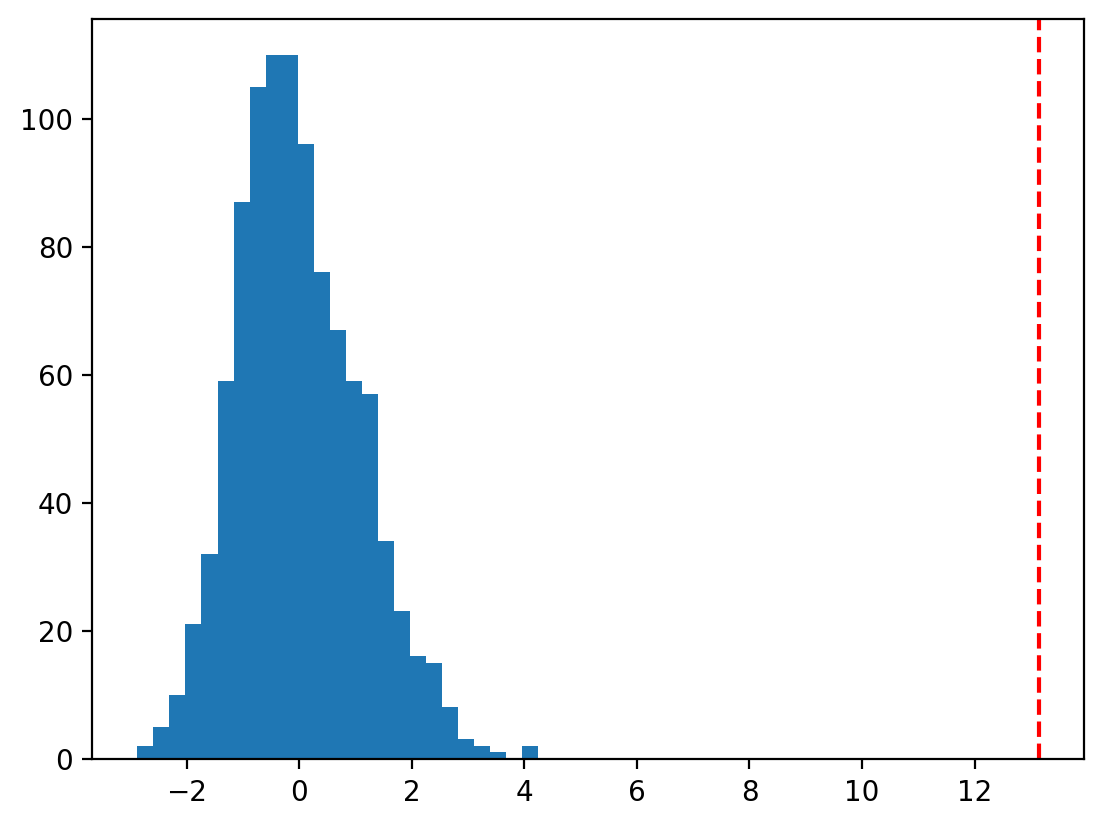

In [11]:
from defiant.null_distribution import phase_shift_OS

OS_obj.set_orf(['hd'])
p,snr,n_dist = phase_shift_OS(OS_obj,inj_params,n_shifts=1000)

plt.hist(n_dist,bins='auto');
plt.axvline(snr, color='r', linestyle='--')
print('P-value:',p)

### multi-component

shifts:   0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.0


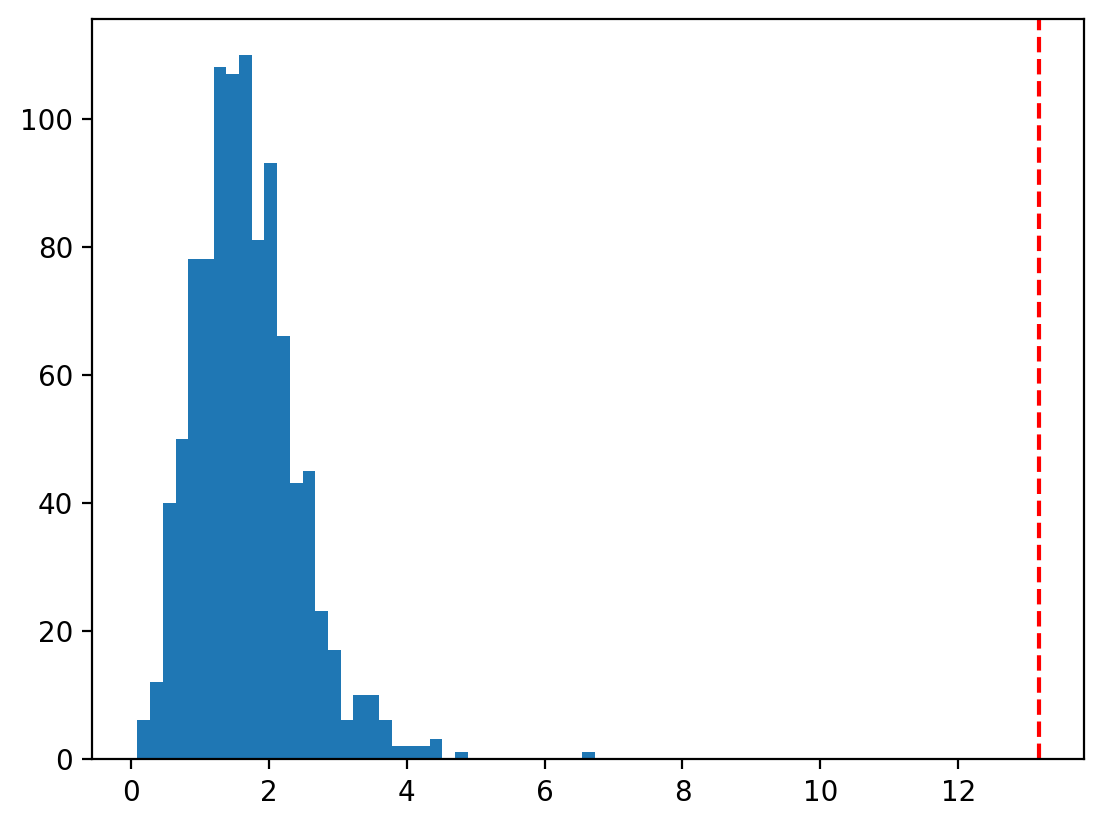

In [12]:
OS_obj.set_orf(['hd','dp','mp'])
p,snr,n_dist = phase_shift_OS(OS_obj,inj_params,n_shifts=1000)

plt.hist(n_dist,bins='auto');
plt.axvline(snr, color='r', linestyle='--')
print('P-value:',p)

## Sky scrambling

In [65]:
def randomly_create_pulsar_positions(OS_obj):
    """A function to randomly create a new design matrix using random pulsar positions

    This function first randomly generates new pulsar positions then computes the
    pulsar separations and the design matrix using the new positions.

    Note that this function only works for isotropic ORFs and is faster with pre-defined
    ORFs. This function does support the use of custom ORFs, but the only attributes
    that the pulsars will have will be the .pos attribute.

    Args:
        OS_obj (defiant.core.OptimalStatistic): The OptimalStatistic object that we want to
            create a new design matrix for.

    Returns:
        tuple: A tuple containing the new pulsar separations and the new design matrix.
            - f_xi (np.ndarray): The new pulsar separations.
            - new_design_matrix (np.ndarray): The new design matrix.
    """
    # Since I intend use utils.compute_pulsar_pair_separations(), we need
    # to create a dummy pulsar object with the .pos attribute (cartesian coordinates)
    class fake_psr:
        def __init__(self):
            self.name = 'fake_psr'
            # We need to get random positions for the pulsars, 
            # Use normal distribution sampling in 3d then normalize the vectors.
            # Need to be careful around (0,0,0), exclude points within 1e-6 of the origin
            self.pos = None
            while self.pos is None:
                pos = np.random.normal(0,1,3)

                if np.sum(pos**2) > 1e-3:
                    self.pos = pos / np.sqrt(np.sum(pos**2))
    
    # Create a list of fake pulsars
    f_psrs = [fake_psr() for i in range(len(OS_obj.psrs))]

    # Get pulsar separations
    f_xi, _ = utils.compute_pulsar_pair_separations(f_psrs, OS_obj._pair_idx)

    new_design_matrix = np.zeros_like(OS_obj.orf_design_matrix.T)
    for i in range(OS_obj.norfs):
        cur_orf = OS_obj.orf_functions[i]
        try:
            # First see if we can supply the pulsar separations directly
            new_design_matrix[i] = cur_orf(f_xi)
        except:
            # Otherwise we need to supply the pulsar objects
            for j,(a,b) in enumerate(OS_obj._pair_idx):
                v = cur_orf(f_psrs[a], f_psrs[b])
                new_design_matrix[i,j] = v
    
    return f_xi, new_design_matrix.T

def randomly_swap_pulsar_positions(OS_obj):
    """A function to randomly make a new design matrix using SWAPPED pulsar positions

    This function first randomly swaps pulsar positions then computes the
    pulsar separations and the design matrix using the new positions. This is useful
    for testing if the pulsar positions are important to the detection statistic.

    Note that this function only works for isotropic ORFs and is faster with pre-defined
    ORFs. This function does support the use of custom ORFs, but the only attributes
    that the pulsars will have will be the .pos attribute.

    Args:
        OS_obj (defiant.core.OptimalStatistic): The OptimalStatistic object that we want to
            create a new design matrix for.

    Returns:
        tuple: A tuple containing the new pulsar separations and the new design matrix.
            - f_xi (np.ndarray): The new pulsar separations.
            - new_design_matrix (np.ndarray): The new design matrix.
    """
    # Since I intend use utils.compute_pulsar_pair_separations(), we need
    # to create a dummy pulsar object with the .pos attribute (cartesian coordinates)
    class swap_psr:
        def __init__(self,pos):
            self.name = 'fake_psr'
            self.pos = pos

    # Get a list of positions
    pos_list = np.array([p.pos for p in OS_obj.psrs])

    # Randomly shuffle the positions
    np.random.shuffle(pos_list)

    # Create a list of fake pulsars
    f_psrs = [swap_psr(pos_list[i]) for i in range(len(OS_obj.psrs))]

    # Get pulsar separations
    f_xi, _ = utils.compute_pulsar_pair_separations(f_psrs, OS_obj._pair_idx)

    new_design_matrix = np.zeros_like(OS_obj.orf_design_matrix.T)
    for i in range(OS_obj.norfs):
        cur_orf = OS_obj.orf_functions[i]
        try:
            # First see if we can supply the pulsar separations directly
            new_design_matrix[i] = cur_orf(f_xi)
        except:
            # Otherwise we need to supply the pulsar objects
            for j,(a,b) in enumerate(OS_obj._pair_idx):
                v = cur_orf(f_psrs[a], f_psrs[b])
                new_design_matrix[i,j] = v
    
    return f_xi, new_design_matrix.T

### single-component

shifts:   0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.0


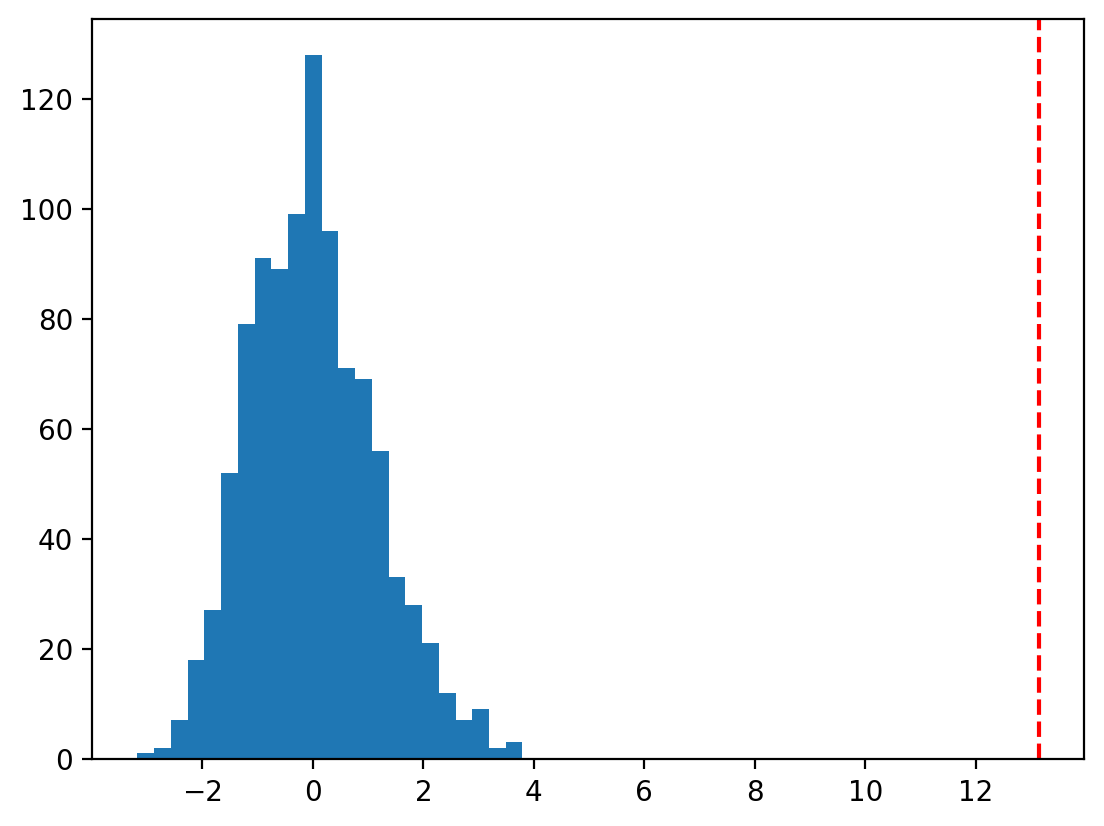

In [79]:
from defiant.null_distribution import sky_scramble_OS

OS_obj.set_orf(['hd'])
p,snr,n_dist = sky_scramble_OS(OS_obj,inj_params,n_scrambles=1000)

plt.hist(n_dist,bins='auto');
plt.axvline(snr, color='r', linestyle='--')
print('P-value:',p)

### multi-component

shifts:   0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.0


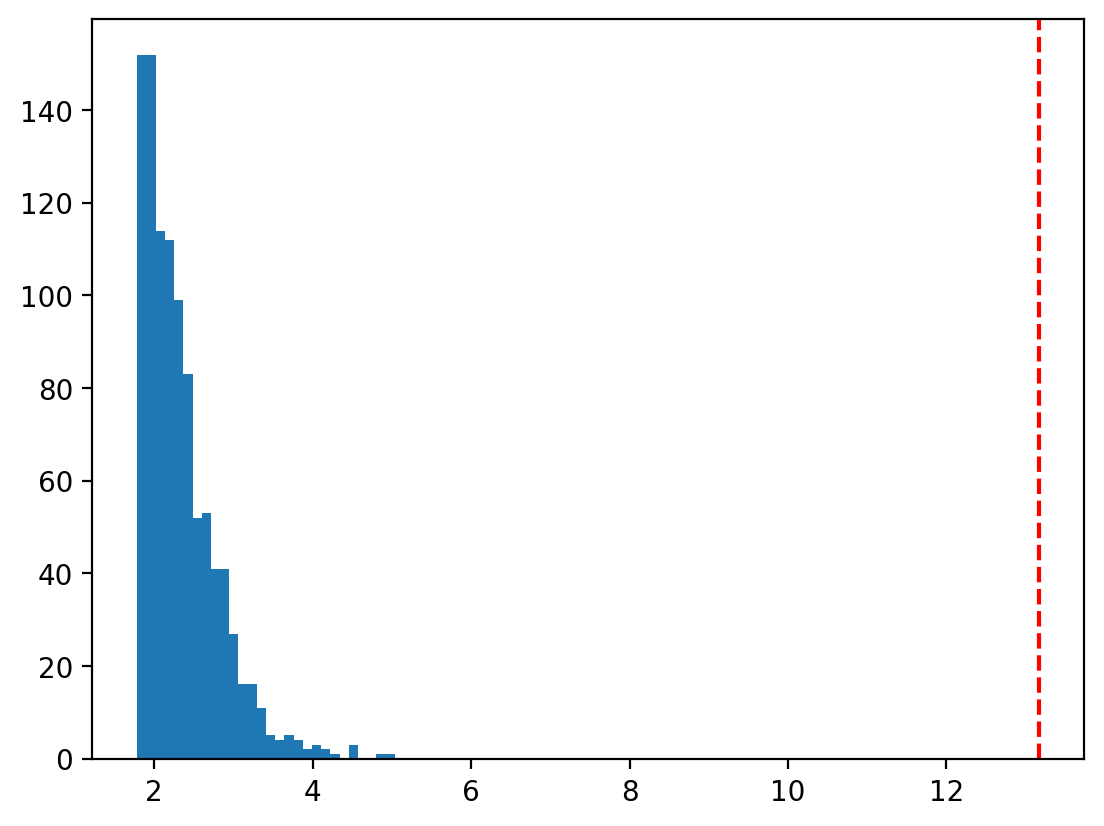

In [80]:
OS_obj.set_orf(['hd','dp','mp'])
p,snr,n_dist = sky_scramble_OS(OS_obj,inj_params,n_scrambles=1000)

plt.hist(n_dist,bins='auto');
plt.axvline(snr, color='r', linestyle='--')
print('P-value:',p)